In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

data 갖고오기

In [3]:
def get_data(dir_path="/content/drive/MyDrive/SOOKTAT/딥러닝/프로젝트/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 290
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path): # closed 폴더 안에 _1.jpg, open 폴더 안에 1.jpg 
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #/content/drive/MyDrive/2기 딥러닝 프로젝트/train/Closed/_0.jpg
                resized_array = cv2.resize(img_array, (34, 26))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [4]:
import os
import cv2

data_train = get_data()

0
1


In [5]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [6]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [7]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [8]:
X = X.reshape(1452, 26, 34,1)

In [9]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

train

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [11]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

In [12]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [13]:
train_dataset = eyes_dataset(X_train, y_train)

In [14]:
type(y_train)

numpy.ndarray

/ model

SiLU activation

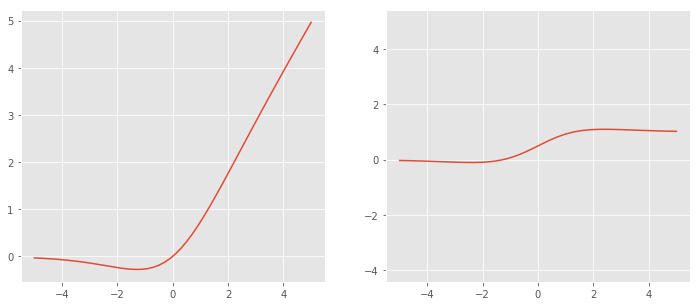

linear 또는 ReLU보다 훨씬 부드러운 형태로 ReLU 및 다른 활성화 함수보다 좋은 성능을 가짐

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.silu(self.fc1(x))
        x = self.fc2(x)


        return x

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
model = Net()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [18]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [19]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")

epoch: [1/50] train_loss: 0.41532 train_acc: 85.26250
epoch: [2/50] train_loss: 0.17763 train_acc: 94.82500
epoch: [3/50] train_loss: 0.12270 train_acc: 95.78750
epoch: [4/50] train_loss: 0.07119 train_acc: 98.35000
epoch: [5/50] train_loss: 0.06887 train_acc: 97.57500
epoch: [6/50] train_loss: 0.06638 train_acc: 97.43750
epoch: [7/50] train_loss: 0.02716 train_acc: 98.95000
epoch: [8/50] train_loss: 0.02079 train_acc: 99.55000
epoch: [9/50] train_loss: 0.00723 train_acc: 100.00000
epoch: [10/50] train_loss: 0.01153 train_acc: 99.70000
epoch: [11/50] train_loss: 0.00524 train_acc: 100.00000
epoch: [12/50] train_loss: 0.00610 train_acc: 99.70000
epoch: [13/50] train_loss: 0.00257 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00168 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00106 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00088 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00135 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00097 train_acc: 100.00000
epoch: [19/

test

In [20]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = eyes_dataset(X_test, y_test, transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

model = Net()
model.to('cuda')
model.eval()

count = 0

In [21]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 48.96552 %
test finish!


ELU activation

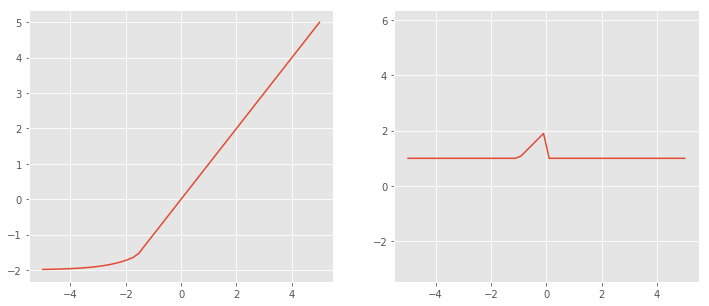

음수일 때 exp를 활용하여 표현
ReLU의 모든 장점을 포함하나 exp 함수를 사용하여 연산 비용이 추가적으로 발생

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net_elu(nn.Module):
    def __init__(self):
        super(Net_elu, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)


        return x

In [25]:
model = Net_elu()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [26]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [27]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: [1/50] train_loss: 0.56802 train_acc: 78.18750
epoch: [2/50] train_loss: 0.16186 train_acc: 94.35000
epoch: [3/50] train_loss: 0.11847 train_acc: 95.56250
epoch: [4/50] train_loss: 0.09613 train_acc: 96.50000
epoch: [5/50] train_loss: 0.05407 train_acc: 98.35000
epoch: [6/50] train_loss: 0.03427 train_acc: 98.95000
epoch: [7/50] train_loss: 0.03225 train_acc: 98.78750
epoch: [8/50] train_loss: 0.02008 train_acc: 99.70000
epoch: [9/50] train_loss: 0.01781 train_acc: 99.85000
epoch: [10/50] train_loss: 0.00553 train_acc: 100.00000
epoch: [11/50] train_loss: 0.00858 train_acc: 99.85000
epoch: [12/50] train_loss: 0.00363 train_acc: 100.00000
epoch: [13/50] train_loss: 0.00174 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00125 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00077 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00053 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00055 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00048 train_acc: 100.00000
epoch: [19/

In [28]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 98.39080 %
test finish!


softmax activation

입력받은 값을 0에서 1사이의 값으로 모두 정규화하며, 여러 개의 출력값을 가짐
출력 값의 총합은 항상 1이 되는 특징

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net_softmax(nn.Module):
    def __init__(self):
        super(Net_softmax, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.softmax(self.fc1(x))
        x = self.fc2(x)


        return x

In [30]:
model = Net_softmax()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [31]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: [1/50] train_loss: 0.69318 train_acc: 49.70000
epoch: [2/50] train_loss: 0.69319 train_acc: 49.37500
epoch: [3/50] train_loss: 0.69319 train_acc: 49.42500
epoch: [4/50] train_loss: 0.69320 train_acc: 50.37500
epoch: [5/50] train_loss: 0.69303 train_acc: 51.83750
epoch: [6/50] train_loss: 0.69322 train_acc: 49.18750
epoch: [7/50] train_loss: 0.69301 train_acc: 52.02500
epoch: [8/50] train_loss: 0.69323 train_acc: 49.50000
epoch: [9/50] train_loss: 0.69325 train_acc: 48.93750
epoch: [10/50] train_loss: 0.69298 train_acc: 51.95000
epoch: [11/50] train_loss: 0.69312 train_acc: 50.52500
epoch: [12/50] train_loss: 0.69333 train_acc: 48.17500
epoch: [13/50] train_loss: 0.69308 train_acc: 51.01250
epoch: [14/50] train_loss: 0.69275 train_acc: 53.71250
epoch: [15/50] train_loss: 0.69291 train_acc: 52.30000
epoch: [16/50] train_loss: 0.69296 train_acc: 51.42500
epoch: [17/50] train_loss: 0.69299 train_acc: 51.25000
epoch: [18/50] train_loss: 0.69348 train_acc: 48.31250
epoch: [19/50] trai

In [32]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avarage acc: 48.96552 %
test finish!


Leaking ReLU activation

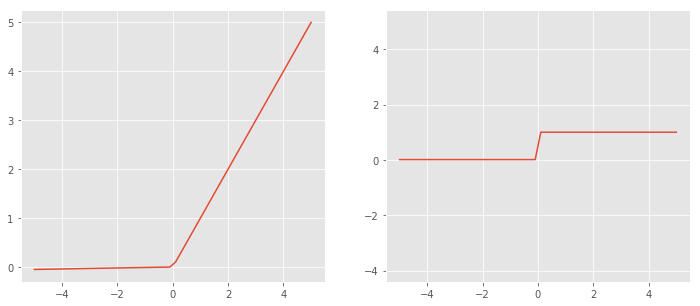

음수에 매우 작은 상수를 곱한 ReLU

그래디언트 값이 0이 되는 ReLU의 단점 극복

ReLU보다 항상 나은 성능을 보이진 않음

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net_leaky_relu(nn.Module):
    def __init__(self):
        super(Net_leaky_relu, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [35]:
model = Net_leaky_relu()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [36]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: [1/50] train_loss: 0.59865 train_acc: 76.65000
epoch: [2/50] train_loss: 0.17093 train_acc: 94.05000
epoch: [3/50] train_loss: 0.11450 train_acc: 95.32500
epoch: [4/50] train_loss: 0.06282 train_acc: 97.73750
epoch: [5/50] train_loss: 0.02946 train_acc: 99.55000
epoch: [6/50] train_loss: 0.04103 train_acc: 98.65000
epoch: [7/50] train_loss: 0.02441 train_acc: 99.25000
epoch: [8/50] train_loss: 0.02758 train_acc: 99.23750
epoch: [9/50] train_loss: 0.00702 train_acc: 100.00000
epoch: [10/50] train_loss: 0.00395 train_acc: 100.00000
epoch: [11/50] train_loss: 0.00528 train_acc: 100.00000
epoch: [12/50] train_loss: 0.00115 train_acc: 100.00000
epoch: [13/50] train_loss: 0.00121 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00093 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00083 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00037 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00043 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00046 train_acc: 100.00000
epoch: [1

In [37]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 98.85057 %
test finish!


=> leaky relu activation이 정확도가 가장 높음

but 제 컴퓨터에선 relu일 때 항상 정확도가 48%대가 나오니.. 신뢰성이 많이 떨어진다.....